In [1]:
#import libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df1 = df.iloc[:,[5,6,9,11]]
df1

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


<Axes: xlabel='final_price', ylabel='Count'>

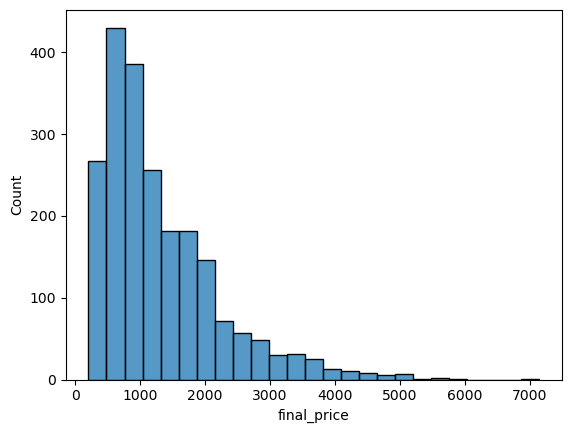

In [5]:
sns.histplot(df1.final_price, bins =25)

## Question 1

There's one column with missing values. What is it?

In [6]:
#Q1)
df1.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

Column 'Screen' has missing values.

## Question 2

What's the median (50% percentile) for variable 'ram'?

In [7]:
#Q2) Median value
df1.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


Median (50%ile) for ram is 16.

## Prepare and split the dataset

In [8]:
np.random.seed(42)

n = len(df1)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df1_shuffled = df1.iloc[idx]

df1_train = df1_shuffled.iloc[:n_train].copy()
df1_val = df1_shuffled.iloc[n_train:n_train+n_val].copy()
df1_test = df1_shuffled.iloc[n_train+n_val:].copy()


y_train_orig = df1_train.final_price.values
y_val_orig = df1_val.final_price.values
y_test_orig = df1_test.final_price.values

y_train = (df1_train.final_price.values)
y_val = (df1_val.final_price.values)
y_test = np.log1p(df1_test.final_price.values)

del df1_train['final_price']
del df1_val['final_price']
del df1_test['final_price']

## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [9]:
#question 3:

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

base = ['ram','storage','screen']

In [10]:
#fill missing value with Zero

def prepare_X(df):
    df1_num = df[base]
    df1_num = df1_num.fillna(0)
    X = df1_num.values
    return X

In [11]:
X_train = prepare_X(df1_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train', round(rmse(y_train, y_pred),2))

train 602.39


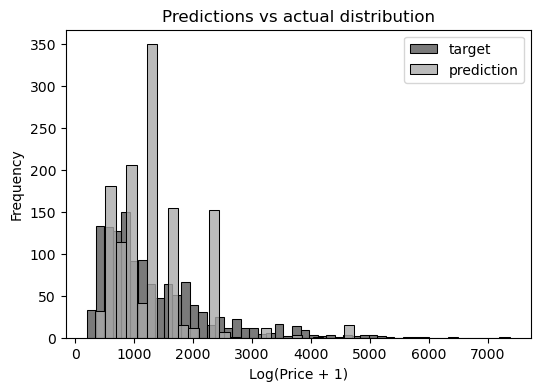

In [12]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [13]:
X_val = prepare_X(df1_val)
y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred),2))

validation 597.36


In [14]:
#since only screen has missing values

mean_df = df1_train.mean()
prep_mean = mean_df['screen']


def prepare_X_mean(df):
    df1_num = df[base]
    df1_num = df1_num.fillna(prep_mean)
    X = df1_num.values
    return X



In [15]:
X_train = prepare_X_mean(df1_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train', round(rmse(y_train, y_pred),2))

train 602.18


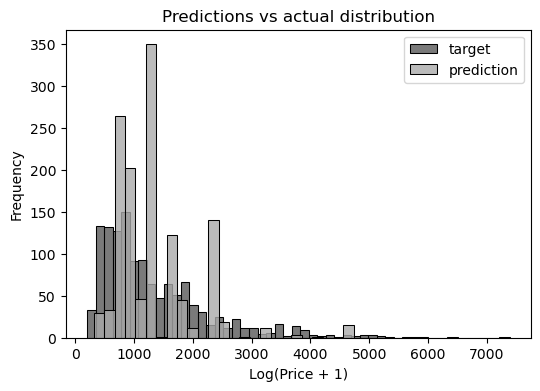

In [16]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [17]:
X_val = prepare_X_mean(df1_val)
y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred),2))

validation 600.27


RMSE is better when we fill missing values with 0.

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
  If there are multiple options, select the smallest r.

In [18]:
#regularized

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [19]:
X_train = prepare_X(df1_train)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('RMSE for','%4s' %r, ' is ', round(rmse(y_val, y_pred),2))

RMSE for    0  is  599.53
RMSE for 0.01  is  599.53
RMSE for  0.1  is  599.49
RMSE for    1  is  599.2
RMSE for    5  is  598.45
RMSE for   10  is  598.04
RMSE for  100  is  597.48


RMSE with R = 0 gives the best result.

## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
  Round the result to 3 decimal digits (round(std, 3))

In [20]:
rmsescore =[]

for seed_value in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed_value)
    
    n = len(df1)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df1_shuffled = df1.iloc[idx]

    df1_train = df1_shuffled.iloc[:n_train].copy()
    df1_val = df1_shuffled.iloc[n_train:n_train+n_val].copy()
    df1_test = df1_shuffled.iloc[n_train+n_val:].copy()


    y_train_orig = df1_train.final_price.values
    y_val_orig = df1_val.final_price.values
    y_test_orig = df1_test.final_price.values

    y_train = (df1_train.final_price.values)
    y_val = (df1_val.final_price.values)
    y_test = np.log1p(df1_test.final_price.values)

    del df1_train['final_price']
    del df1_val['final_price']
    del df1_test['final_price']

    X_train = prepare_X(df1_train)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df1_val)
    y_pred = w_0 + X_val.dot(w)

    rmse_output = rmse(y_val, y_pred)

    rmsescore.append(rmse_output)
    print('RMSE for seed value','%2s' %seed_value, ' is ', rmse_output)
    
print("\n")
print('The standard deviation is ',round(np.std(rmsescore),3))

RMSE for seed value  0  is  565.4520868770995
RMSE for seed value  1  is  636.7985423056726
RMSE for seed value  2  is  588.955869790796
RMSE for seed value  3  is  597.8148920012515
RMSE for seed value  4  is  571.962791511103
RMSE for seed value  5  is  573.238325661895
RMSE for seed value  6  is  647.3438328407194
RMSE for seed value  7  is  550.4398184485962
RMSE for seed value  8  is  587.3335036169963
RMSE for seed value  9  is  576.101792943313


The standard deviation is  29.176


## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [21]:
np.random.seed(9)

n = len(df1)

n_test = int(0.2 * n)
n_train = n - n_test

idx = np.arange(n)
np.random.shuffle(idx)

df1_shuffled = df1.iloc[idx]

df1_train = df1_shuffled.iloc[:n_train].copy()
df1_test = df1_shuffled.iloc[n_train:].copy()

y_train_orig = df1_train.final_price.values
y_test_orig = df1_test.final_price.values

y_train = (df1_train.final_price.values)
y_test = np.log1p(df1_test.final_price.values)

del df1_train['final_price']
del df1_test['final_price']


In [22]:
X_train = prepare_X(df1_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

y_pred = w_0 + X_train.dot(w)
print('train', round(rmse(y_train, y_pred),2))

train 586.19
